# Multinomial Logistic Regression - Wine

## Import Libraries

In [1]:
import warnings  # Suppress warnings

warnings.filterwarnings("ignore")

import os  # Interact with the operating system.
import sys  # Read system parameters.
from io import StringIO  # Read and write strings as files
from time import time
from urllib.parse import urlparse  # Parse URL and extract path component

import matplotlib as mpl  # Create 2D charts.
import matplotlib.pyplot as plt
import numpy as np  # Work with multi-dimensional arrays and matrices.
import pandas as pd  # Manipulate and analyze data frames.
import requests  # Send HTTP requests
import seaborn as sns  # Streamline charting.
import sklearn  # Perform feature engineering and machine learning.
from scipy.stats import zscore
from sklearn import datasets  # ML datasets
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve,
)
from sklearn.model_selection import cross_val_predict, cross_val_score, train_test_split
from sklearn.utils import shuffle

# Summarize software libraries used.
print("Libraries used in this project:")
print("- NumPy {}".format(np.__version__))
print("- pandas {}".format(pd.__version__))
print("- scikit-learn {}".format(sklearn.__version__))
# print("- Matplotlib {}".format(matplotlib.__version__))
print("- Seaborn {}".format(sns.__version__))
print("- Python {}\n".format(sys.version))
print("\nSummary of software packages complete.\n")

Libraries used in this project:
- NumPy 1.22.3
- pandas 1.4.1
- scikit-learn 1.2.2
- Seaborn 0.13.0
- Python 3.9.20 (main, Oct  3 2024, 02:27:54) 
[Clang 14.0.6 ]


Summary of software packages complete.



## Load Wine dataset.


In [2]:
wine = datasets.load_wine()
print("Loaded {} wine records.".format(len(wine.data)))

Loaded 178 wine records.


**Convert array to pandas DataFrame.**

In [3]:
df = pd.DataFrame(wine["data"], columns=wine["feature_names"])
df["target"] = wine["target"]

**Shuffle the dataset.**

In [4]:
df = shuffle(df.copy(), random_state=765)
df.reset_index(inplace=True, drop=True)

## Explore Data

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  targe

**Spotlights** 

- The dataset comprises 178 entries and 14 features.
- All features are represented as floating-point numbers, with the exception of the target feature, which consists of integer values. This target feature indicates the wine classification, categorized as 0, 1, or 2, thus creating a multi-class classification challenge.
- There are no instances of missing data; every entry is complete across all features.
- The majority of the features pertain to the chemical properties of the wine, such as alcohol content, magnesium concentration, and phenol count. Additionally, some features relate to the visual characteristics of the wine, including color intensity and hue.
- Overall, the dataset is quite clean and consistent, although it could still benefit from some preparatory steps.

**Examine the First 5 Records**

In [6]:
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,13.69,3.26,2.54,20.0,107.0,1.83,0.56,0.50,0.80,5.88,0.96,1.82,680.0,2
1,12.67,0.98,2.24,18.0,99.0,2.20,1.94,0.30,1.46,2.62,1.23,3.16,450.0,1
2,13.86,1.35,2.27,16.0,98.0,2.98,3.15,0.22,1.85,7.22,1.01,3.55,1045.0,0
3,13.73,1.50,2.70,22.5,101.0,3.00,3.25,0.29,2.38,5.70,1.19,2.71,1285.0,0
4,13.41,3.84,2.12,18.8,90.0,2.45,2.68,0.27,1.48,4.28,0.91,3.00,1035.0,0


### Analyze Summary Statistics

In [7]:
with pd.option_context("float_format", "{:.2f}".format):
    print(df.describe())

       alcohol  malic_acid    ash  alcalinity_of_ash  magnesium  \
count   178.00      178.00 178.00             178.00     178.00   
mean     13.00        2.34   2.37              19.49      99.74   
std       0.81        1.12   0.27               3.34      14.28   
min      11.03        0.74   1.36              10.60      70.00   
25%      12.36        1.60   2.21              17.20      88.00   
50%      13.05        1.87   2.36              19.50      98.00   
75%      13.68        3.08   2.56              21.50     107.00   
max      14.83        5.80   3.23              30.00     162.00   

       total_phenols  flavanoids  nonflavanoid_phenols  proanthocyanins  \
count         178.00      178.00                178.00           178.00   
mean            2.30        2.03                  0.36             1.59   
std             0.63        1.00                  0.12             0.57   
min             0.98        0.34                  0.13             0.41   
25%             1.74 

- A lack of expertise in wine or an understanding of alcohol chemistry, may make it challenging to discern which characteristics are crucial for classifying wine.
- The data does not seem to present significant outliers for any of the characteristics, but a visual distribution will provide further clarity.
- It is evident that the levels of magnesium and particularly proline are considerably higher compared to other features, indicating that some scaling may be necessary.

## Analyze Feature Distributions
- A deeper analysis of the data could enhance your understanding of the key factors influencing wine classification.
- Visual representations of the data will aid in identifying trends and anomalies that may not be immediately apparent.

**Plot histograms**

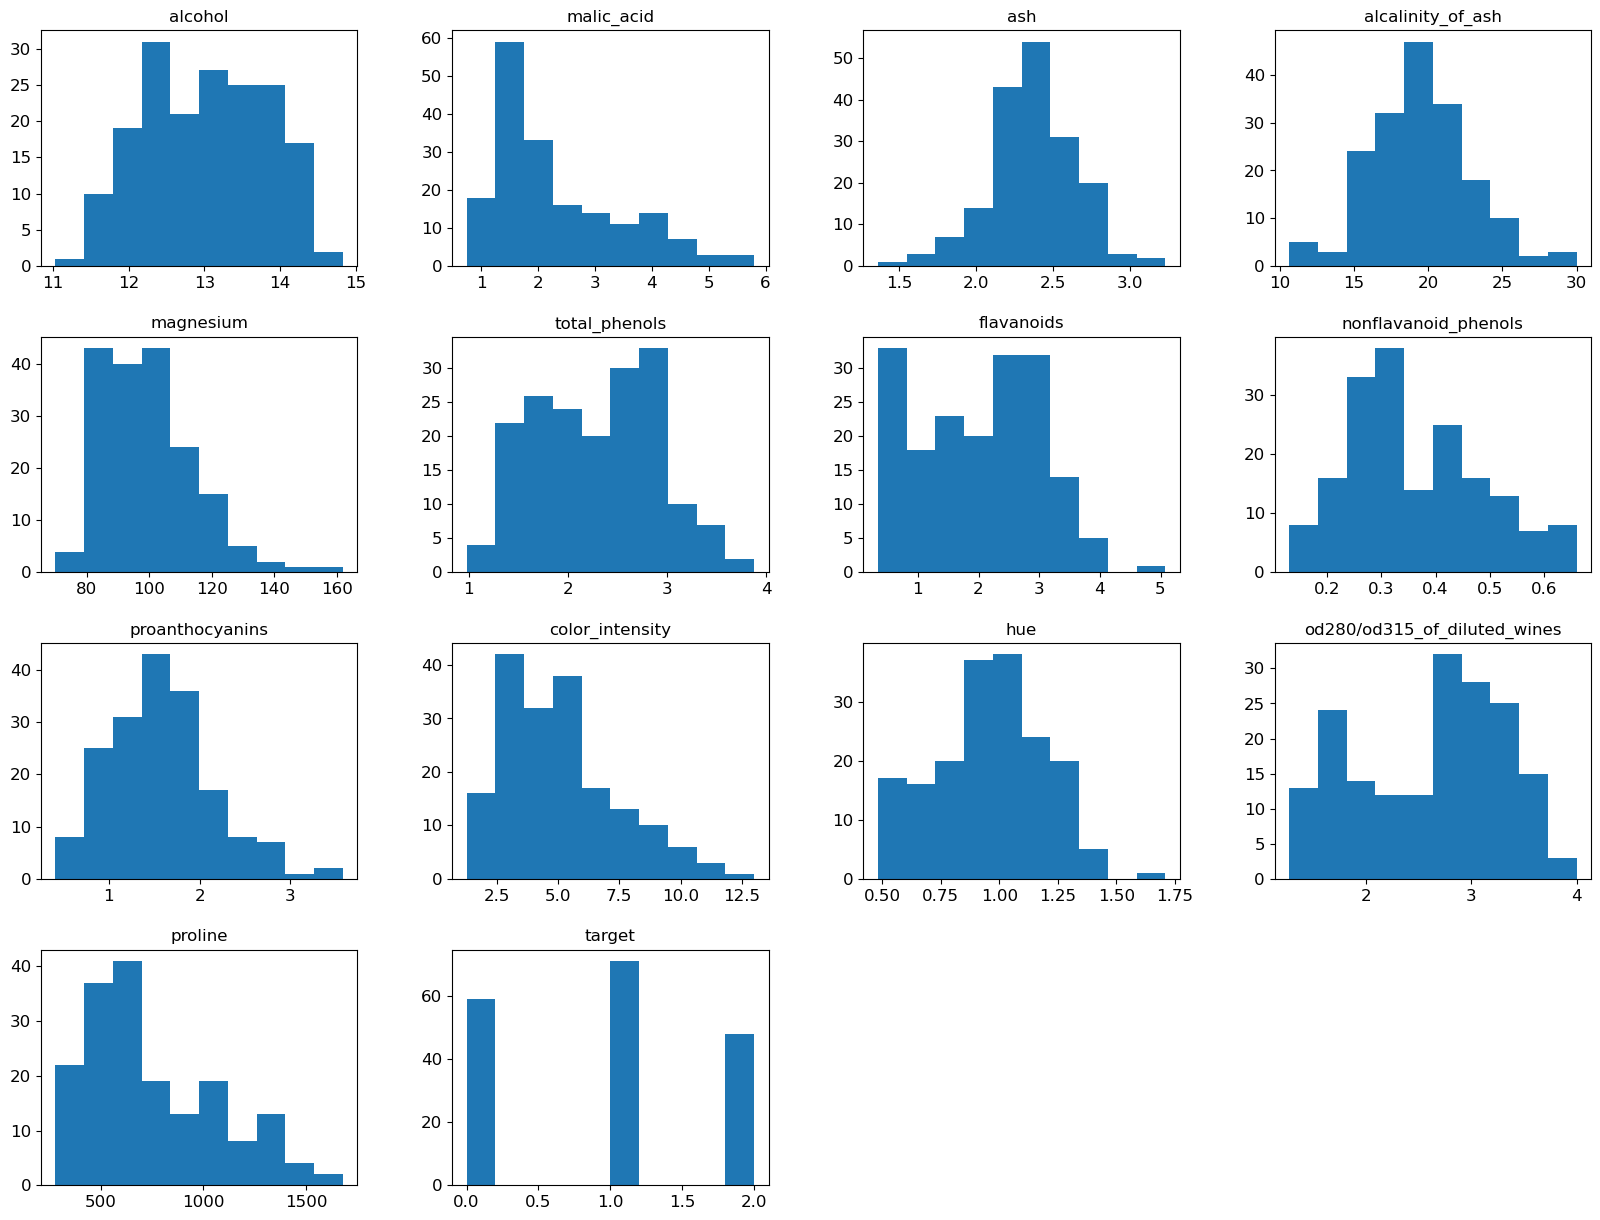

<Figure size 640x480 with 0 Axes>

In [8]:
%matplotlib inline
mpl.rc("axes", labelsize=14)
mpl.rc("xtick", labelsize=12)
mpl.rc("ytick", labelsize=12)

df.hist(
    figsize=(20, 15),
    grid=False,
)
plt.figure();

- Generally, the histograms support the notion that the dataset lacks significant extreme outliers.
- Certain features, including malic_acid and color_intensity, display a noticeable right skew.
- Additionally, the distribution of class labels (target) appears to be relatively balanced. 
- Overall, the visual representations indicate a consistent pattern across the data.
- The analysis suggests that while some features show skewness, the overall outlier presence is minimal.

**Analyze 'target' class counts**

In [9]:
target_class_counts = df["target"].value_counts()

print("(Class 0):", target_class_counts[0], "\n")
print("(Class 1):", target_class_counts[1], "\n")
print("(Class 2):", target_class_counts[2], "\n")

(Class 0): 59 

(Class 1): 71 

(Class 2): 48 



<Axes: title={'center': 'Count (taret)'}>

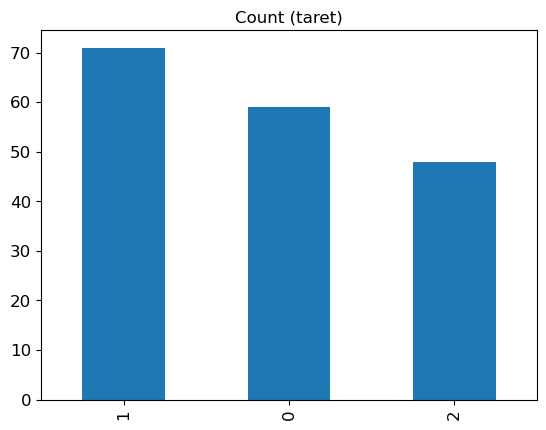

In [10]:
target_class_counts.plot(kind="bar", title="Count (taret)", grid=False)

**Spotlights**

The graph confirms the number of categorical observations printed above. 

- Class 0: 59
- Class 1: 71
- Calls 2: 48
  

## Separate the Dataset

Instead of employing the holdout method to divide the datasets into training and test sets, cross-validation will be utilized for training the data. The dependent variable, referred to as 'target', represents the value that needs to be predicted. Consequently, it will be extracted from the training dataset and placed into a distinct DataFrame designated for labels.At this stage, it is simply a matter of isolating the labels from the training set (X) and storing them in a separate vector (y).

In [11]:
# Create label columns
labels = ["target"]

# Create predictors list
predictors = [
    "alcohol",
    "malic_acid",
    "ash",
    "alcalinity_of_ash",
    "magnesium",
    "total_phenols",
    "flavanoids",
    "nonflavanoid_phenols",
    "proanthocyanins",
    "color_intensity",
    "hue",
    "od280/od315_of_diluted_wines",
    "proline",
]

X, y = df[predictors], df[labels]

**Compare the number of columns in the original data to the new training and label sets.**

In [12]:
print(f"Original set:    {df.shape}")
print("------------------------------")
print(f"Training data:   {X.shape}")
print(f"Training labels: {y.shape}")

Original set:    (178, 14)
------------------------------
Training data:   (178, 13)
Training labels: (178, 1)


**Implement a logarithmic transformation to normalize 'magnesium' and 'proline'.**

In [13]:
X = X.copy()
X["proline"] = np.log(X["proline"])
X["magnesium"] = np.log(X["magnesium"])

**Analyze the log transformation outcomes**.

In [14]:
with pd.option_context("float_format", "{:.2f}".format):
    print(X["magnesium"].describe())
    print("\n-----------------------")
    print(X["proline"].describe())

count   178.00
mean      4.59
std       0.14
min       4.25
25%       4.48
50%       4.58
75%       4.67
max       5.09
Name: magnesium, dtype: float64

-----------------------
count   178.00
mean      6.53
std       0.42
min       5.63
25%       6.22
50%       6.51
75%       6.89
max       7.43
Name: proline, dtype: float64


In [15]:
X.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline
0,13.69,3.26,2.54,20.0,4.672829,1.83,0.56,0.50,0.80,5.88,0.96,1.82,6.522093
1,12.67,0.98,2.24,18.0,4.595120,2.20,1.94,0.30,1.46,2.62,1.23,3.16,6.109248
2,13.86,1.35,2.27,16.0,4.584967,2.98,3.15,0.22,1.85,7.22,1.01,3.55,6.951772
3,13.73,1.50,2.70,22.5,4.615121,3.00,3.25,0.29,2.38,5.70,1.19,2.71,7.158514
4,13.41,3.84,2.12,18.8,4.499810,2.45,2.68,0.27,1.48,4.28,0.91,3.00,6.942157


**Spotlights**

- A basic logarithmic transformation has effectively minimized the numeric range of these values. The previous maximum for magnesium was 162.00, which has now been reduced to 5.09. Similarly, the maximum for proline, originally at 1680.00, is now 7.43.

While this feature scaling may not be particularly beneficial for standard logistic regression models, it does enhance the efficiency of gradient descent and contributes positively to regularized regression models, both of which will be applied. The logarithmic adjustment has streamlined the data, making it more manageable and interpretable. The significant reduction in maximum values allows for better handling of the data in subsequent analyses. Implementing this scaling technique can lead to improved performance in specific regression applications.

## Develop a Multinomial Regression Model 

The LogisticRegression() class serves the purpose of both binary and multi-class classification tasks in scikit-learn. To enable multi-class classification, the multi_class parameter must be specified. There are two distinct methods available; the multinomial approach guarantees the application of the softmax function for probability predictions. Additionally, the solver employed is the stochastic average gradient (SAG) method.

In [16]:
multinomial = LogisticRegression(
    solver="sag", multi_class="multinomial", max_iter=10000
)

print("Multinomial logistic regression model created.")

Multinomial logistic regression model created.


## Train the Model - Stratified K-Fold Cross Validation

**Utilize stratified k-fold cross-validation to train the model effectively.**

In [17]:
# Train model and make predictions using test data.
time_start = time()
predict = cross_val_predict(multinomial, X, np.ravel(y), cv=5)
time_end = time()
time_to_train = (time_end - time_start) * 1000

# Retrieve mean score of test folds.
score = cross_val_score(multinomial, X, np.ravel(y), cv=5).mean()

print(
    "Multinomial logistic regression model took {:.2f} milliseconds to fit.".format(
        time_to_train
    )
)

print(f"Mean score on test sets: {score.mean() * 100 :.0f}%")

Multinomial logistic regression model took 152.25 milliseconds to fit.
Mean score on test sets: 95%


**Spotlights** 

- The duration of the training process would have increased by approximately fivefold without adjusting those two disproportionately scaled features **'magnesium' and 'proline'**.
- The average score achieved on the test sets is notably high, standing at 95%.

**Acquire the probabilities associated with predictions.** 

The subsequent actions will involve obtaining the probabilities of the predictions. Utilize the test dataset to assess the accuracy of the predictions, and ultimately, analyze instances of the predictions in relation to the actual wine outcomes.

In [18]:
probabilities = cross_val_predict(
    multinomial, X, np.ravel(y), cv=5, method="predict_proba"
)

compare_results = X.copy()
compare_results["magnesium"] = np.exp(compare_results["magnesium"])
compare_results["proline"] = np.exp(compare_results["proline"])
compare_results["PredictedWine"] = predict
compare_results["ActualWine"] = y.copy()
compare_results["ProbWine0"] = np.round(probabilities[:, 0] * 100, 2)
compare_results["ProbWine1"] = np.round(probabilities[:, 1] * 100, 2)
compare_results["ProbWine2"] = np.round(probabilities[:, 2] * 100, 2)

compare_results.head(21)

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,PredictedWine,ActualWine,ProbWine0,ProbWine1,ProbWine2
0,13.69,3.26,2.54,20.0,107.0,1.83,0.56,0.50,0.80,5.88,0.96,1.82,680.0,2,2,1.59,1.93,96.48
1,12.67,0.98,2.24,18.0,99.0,2.20,1.94,0.30,1.46,2.62,1.23,3.16,450.0,1,1,7.15,92.75,0.10
2,13.86,1.35,2.27,16.0,98.0,2.98,3.15,0.22,1.85,7.22,1.01,3.55,1045.0,0,0,99.39,0.59,0.03
3,13.73,1.50,2.70,22.5,101.0,3.00,3.25,0.29,2.38,5.70,1.19,2.71,1285.0,1,0,46.80,52.59,0.61
4,13.41,3.84,2.12,18.8,90.0,2.45,2.68,0.27,1.48,4.28,0.91,3.00,1035.0,0,0,72.74,26.58,0.68
5,12.20,3.03,2.32,19.0,96.0,1.25,0.49,0.40,0.73,5.50,0.66,1.83,510.0,2,2,1.02,2.04,96.94
6,13.83,1.65,2.60,17.2,94.0,2.45,2.99,0.22,2.29,5.60,1.24,3.37,1265.0,0,0,97.71,2.26,0.03
7,12.69,1.53,2.26,20.7,80.0,1.38,1.46,0.58,1.62,3.05,0.96,2.06,495.0,1,1,1.22,95.46,3.31
8,14.75,1.73,2.39,11.4,91.0,3.10,3.69,0.43,2.81,5.40,1.25,2.73,1150.0,0,0,99.85,0.15,0.00
9,12.43,1.53,2.29,21.5,86.0,2.74,3.15,0.39,1.77,3.94,0.69,2.84,352.0,1,1,5.52,94.36,0.12


**Spotlights** 

- The magnesium and proline features transformed earlier have now been scaled back to their original values.
- The predictions and actual values for each wine are displayed as their own columns at the end of the data frame.
- Each of the three classes has its own ProbWine# column, indicating what proportion of those three classes the model felt was most likely for a given example. The classification prediction is derived from the class with the highest probability.

## Examine Correlations to Target

In [25]:
# Create features list
features = [
    "target",
    "alcalinity_of_ash",
    "nonflavanoid_phenols",
    "malic_acid",
    "color_intensity",
    "ash",
    "magnesium",
    "alcohol",
    "proanthocyanins",
    "hue",
    "proline",
    "total_phenols",
    "od280/od315_of_diluted_wines",
    "flavanoids",
]

df[features].corr()

,target,alcalinity_of_ash,nonflavanoid_phenols,malic_acid,color_intensity,ash,magnesium,alcohol,proanthocyanins,hue,proline,total_phenols,od280/od315_of_diluted_wines,flavanoids
target,1.000000,0.517859,0.489109,0.437776,0.265668,-0.049643,-0.209179,-0.328222,-0.499130,-0.617369,-0.633717,-0.719163,-0.788230,-0.847498
alcalinity_of_ash,0.517859,1.000000,0.361922,0.288500,0.018732,0.443367,-0.083333,-0.310235,-0.197327,-0.273955,-0.440597,-0.321113,-0.276769,-0.351370
nonflavanoid_phenols,0.489109,0.361922,1.000000,0.292977,0.139057,0.186230,-0.256294,-0.155929,-0.365845,-0.262640,-0.311385,-0.449935,-0.503270,-0.537900
malic_acid,0.437776,0.288500,0.292977,1.000000,0.248985,0.164045,-0.054575,0.094397,-0.220746,-0.561296,-0.192011,-0.335167,-0.368710,-0.411007
color_intensity,0.265668,0.018732,0.139057,0.248985,1.000000,0.258887,0.199950,0.546364,-0.025250,-0.521813,0.316100,-0.055136,-0.428815,-0.172379
ash,-0.049643,0.443367,0.186230,0.164045,0.258887,1.000000,0.286587,0.211545,0.009652,-0.074667,0.223626,0.128980,0.003911,0.115077
magnesium,-0.209179,-0.083333,-0.256294,-0.054575,0.199950,0.286587,1.000000,0.270798,0.236441,0.055398,0.393351,0.214401,0.066004,0.195784
alcohol,-0.328222,-0.310235,-0.155929,0.094397,0.546364,0.211545,0.270798,1.000000,0.136698,-0.071747,0.643720,0.289101,0.072343,0.236815
proanthocyanins,-0.499130,-0.197327,-0.365845,-0.220746,-0.025250,0.009652,0.236441,0.136698,1.000000,0.295544,0.330417,0.612413,0.519067,0.652692
hue,-0.617369,-0.273955,-0.262640,-0.561296,-0.521813,-0.074667,0.055398,-0.071747,0.295544,1.000000,0.236183,0.433681,0.565468,0.543479


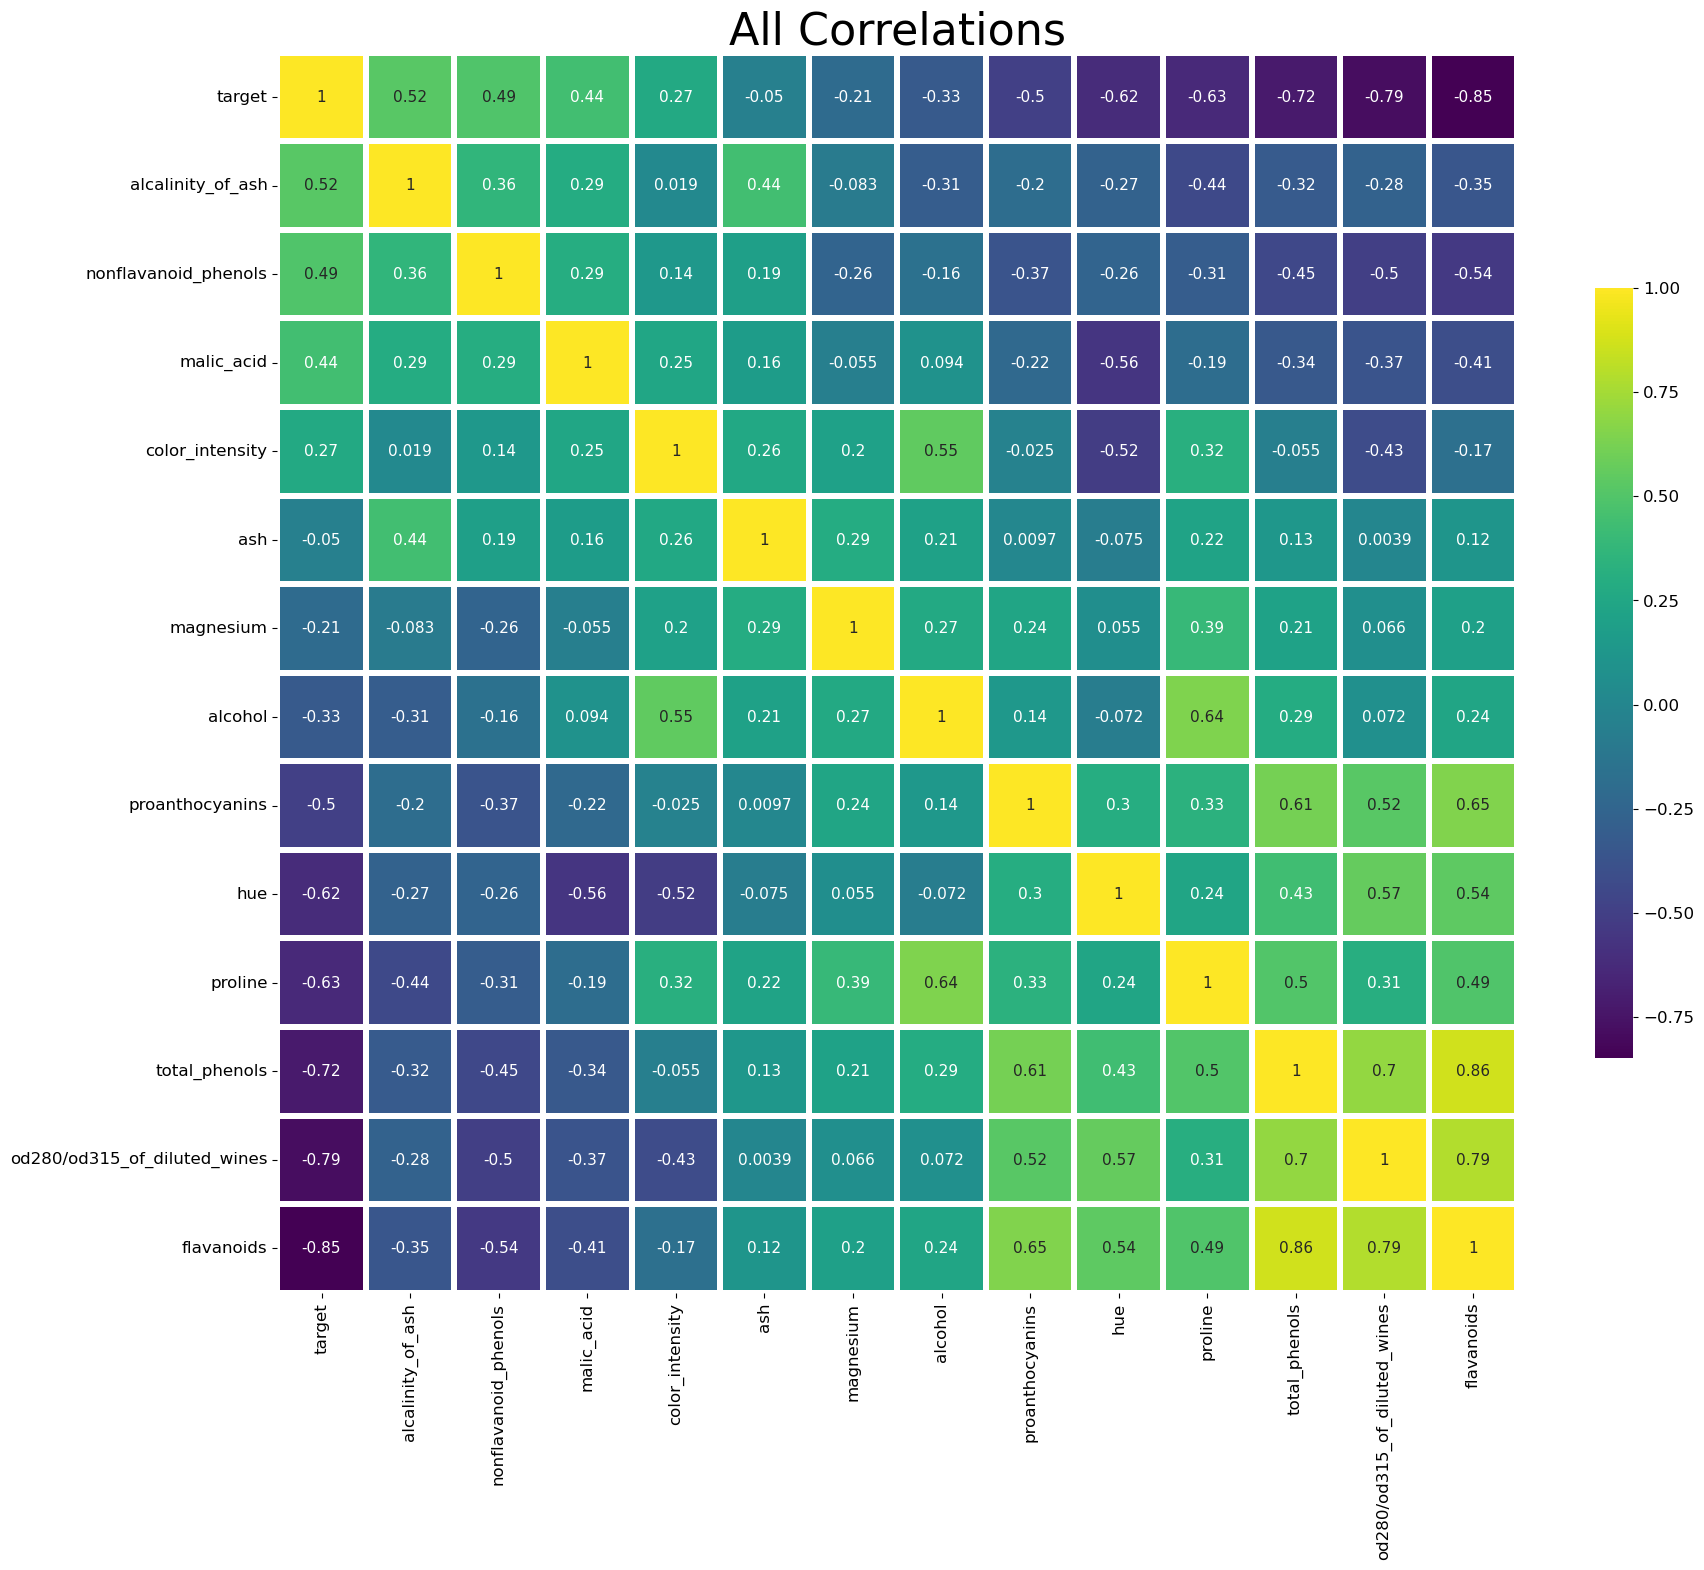

In [26]:
f, axes = plt.subplots(figsize=(20, 20))
plt.title("All Correlations", fontsize=32)
#  Plot the correlation matrix as a heatmap using the Seaborn library
sns.heatmap(
    df[features].corr(),
    linewidths=3.0,
    square=True,
    cmap="viridis",
    linecolor="w",
    annot=True,
    annot_kws={"size": 11},
    cbar_kws={"shrink": 0.5},
);

**Spotlights** 

- Nine features show a negative relationship with the target, indicating an inverse correlation.
- flavonoids stand out as the most significant feature affecting the class, boasting a strong -85% correlation with the target.
- alkalinity_of_ash is recognized as the top positive attribute influencing the class, with a correlation of 52%.
